# Détection de la Saisonnalité 

On considère le problème de la modélisation de données de séries temporelles avec plusieurs composantes saisonnières ayant des périodicités différentes :

$$y_t = \mu_t + \gamma^{(1)}_t + \gamma^{(2)}_t
$$

où $\mu_t$ représente la tendance, $\gamma^{(1)}_t$ correspond à une composante saisonnière avec une période relativement faible, et $ \gamma^{(2)}_t$ représente une variation saisonnière d'une période plus longue. On ajoute un terme fixe d'interception pour la tendance, considère à la fois $\gamma^{(1)}_t$ et $\gamma^{(2)}_t$ comme étant stochastiques afin que les modèles saisonniers puissent varier dans le temps.

On va générer des données conformes à ce modèle et modéliser les termes saisonniers de plusieurs façons afin de prédire les réalisations futures de la série.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(20,12))
plt.rc("font", size=14)

On simule 300 périodes et deux termes saisonniers paramétrés dans le domaine fréquentiel ayant des périodes respectivement de 10 et 100, et avec nombre d'harmoniques (de Fourier) respectivement de 3 et 2. En sus, les variances de leurs parties stochastiques sont de 4 et 9, respectivement.

In [2]:
def simulate_seasonal_term(periodicity, total_cycles, noise_std=1.,harmonics=None):

    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration
    series = np.zeros(total_timesteps)
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (gamma_jt[j - 1] * cos_j
                                 + gamma_star_jt[j - 1] * sin_j
                                 + noise_std * np.random.randn())
            gamma_star_jtp1[j - 1] = (- gamma_jt[j - 1] * sin_j
                                      + gamma_star_jt[j - 1] * cos_j
                                      + noise_std * np.random.randn())
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:]

    return wanted_series

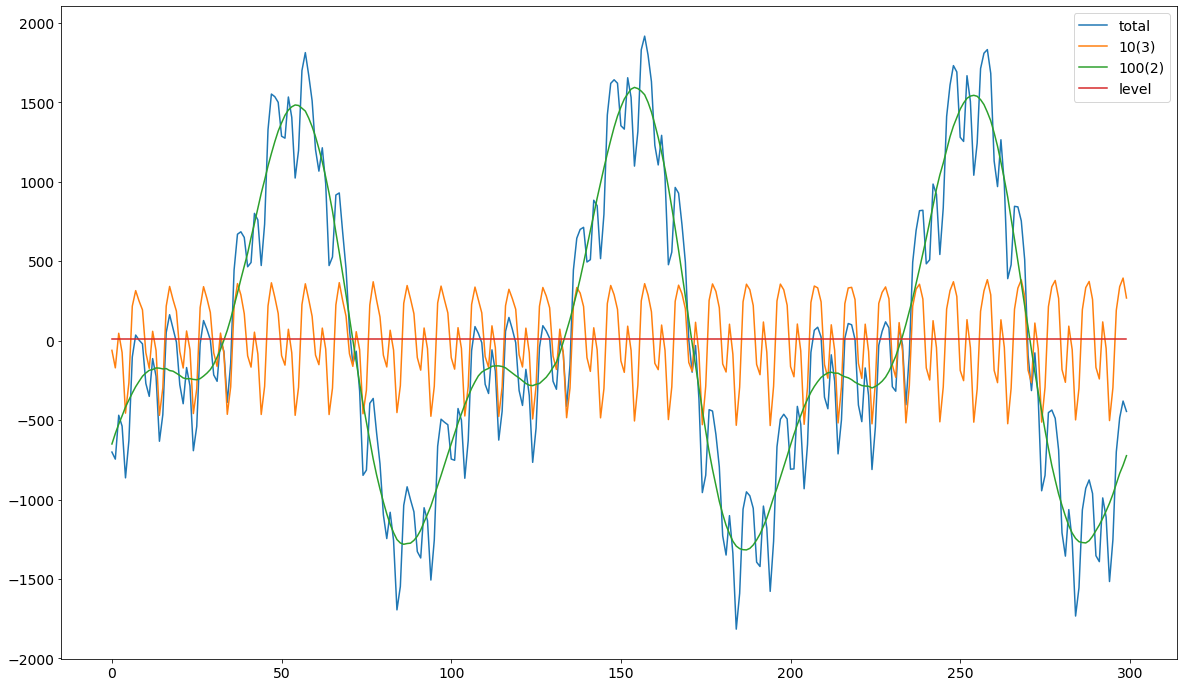

In [3]:
duration = 100 * 3
periodicities = [10, 100]
num_harmonics = [3, 2]
std = np.array([2, 3])
np.random.seed(8678309)

terms = []
for ix, _ in enumerate(periodicities):
    s = simulate_seasonal_term(
        periodicities[ix],
        duration / periodicities[ix],
        harmonics=num_harmonics[ix],
        noise_std=std[ix])
    terms.append(s)
terms.append(np.ones_like(terms[0]) * 10.)
series = pd.Series(np.sum(terms, axis=0))
df = pd.DataFrame(data={'total': series,
                        '10(3)': terms[0],
                        '100(2)': terms[1],
                        'level':terms[2]})
h1, = plt.plot(df['total'])
h2, = plt.plot(df['10(3)'])
h3, = plt.plot(df['100(2)'])
h4, = plt.plot(df['level'])
plt.legend(['total','10(3)','100(2)', 'level'])
plt.show()

## Modélisation en Domaine Fréquentiel

La méthode suivante est un modèle à composantes non observées, où la tendance est modélisée par un intercept fixe et les composantes saisonnières sont modélisées à l'aide de fonctions trigonométriques avec des périodicités primaires de 10 et 100, respectivement, et un nombre d'harmoniques de 3 et 2, respectivement.

Le processus de la série temporelle peut être écrit comme suit :

$$
\begin{split}\begin{align}
y_t & = \mu_t + \gamma^{(1)}_t + \gamma^{(2)}_t + \varepsilon_t\\
\mu_{t+1} & = \mu_t \\
\gamma^{(1)}_{t} &= \sum_{j=1}^2 \gamma^{(1)}_{j, t} \\
\gamma^{(2)}_{t} &= \sum_{j=1}^3 \gamma^{(2)}_{j, t}\\
\gamma^{(1)}_{j, t+1} &= \gamma^{(1)}_{j, t}\cos(\lambda_j) + \gamma^{*, (1)}_{j, t}\sin(\lambda_j) + \omega^{(1)}_{j,t}, ~j = 1, 2, 3\\
\gamma^{*, (1)}_{j, t+1} &= -\gamma^{(1)}_{j, t}\sin(\lambda_j) + \gamma^{*, (1)}_{j, t}\cos(\lambda_j) + \omega^{*, (1)}_{j, t}, ~j = 1, 2, 3\\
\gamma^{(2)}_{j, t+1} &= \gamma^{(2)}_{j, t}\cos(\lambda_j) + \gamma^{*, (2)}_{j, t}\sin(\lambda_j) + \omega^{(2)}_{j,t}, ~j = 1, 2\\
\gamma^{*, (2)}_{j, t+1} &= -\gamma^{(2)}_{j, t}\sin(\lambda_j) + \gamma^{*, (2)}_{j, t}\cos(\lambda_j) + \omega^{*, (2)}_{j, t}, ~j = 1, 2\\
\end{align}\end{split}
$$

où $\varepsilon_t$ est un bruit blanc, $\omega^{(1)}_{j,t}$ sont des variables *i.i.d.* $\mathcal N(0, \sigma^2_1)$ et $\omega^{(2)}_{j,t}$ sont des variables *i.i.d* $\mathcal N(0, \sigma^2_2)$, où $\sigma_1 = 2$.

                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                  300
Model:                                fixed intercept   Log Likelihood               -1145.631
                    + stochastic freq_seasonal(10(3))   AIC                           2295.261
                   + stochastic freq_seasonal(100(2))   BIC                           2302.594
Date:                                Thu, 05 Jan 2023   HQIC                          2298.200
Time:                                        23:24:49                                         
Sample:                                             0                                         
                                                - 300                                         
Covariance Type:                                  opg                                         
                                  coef    std err 

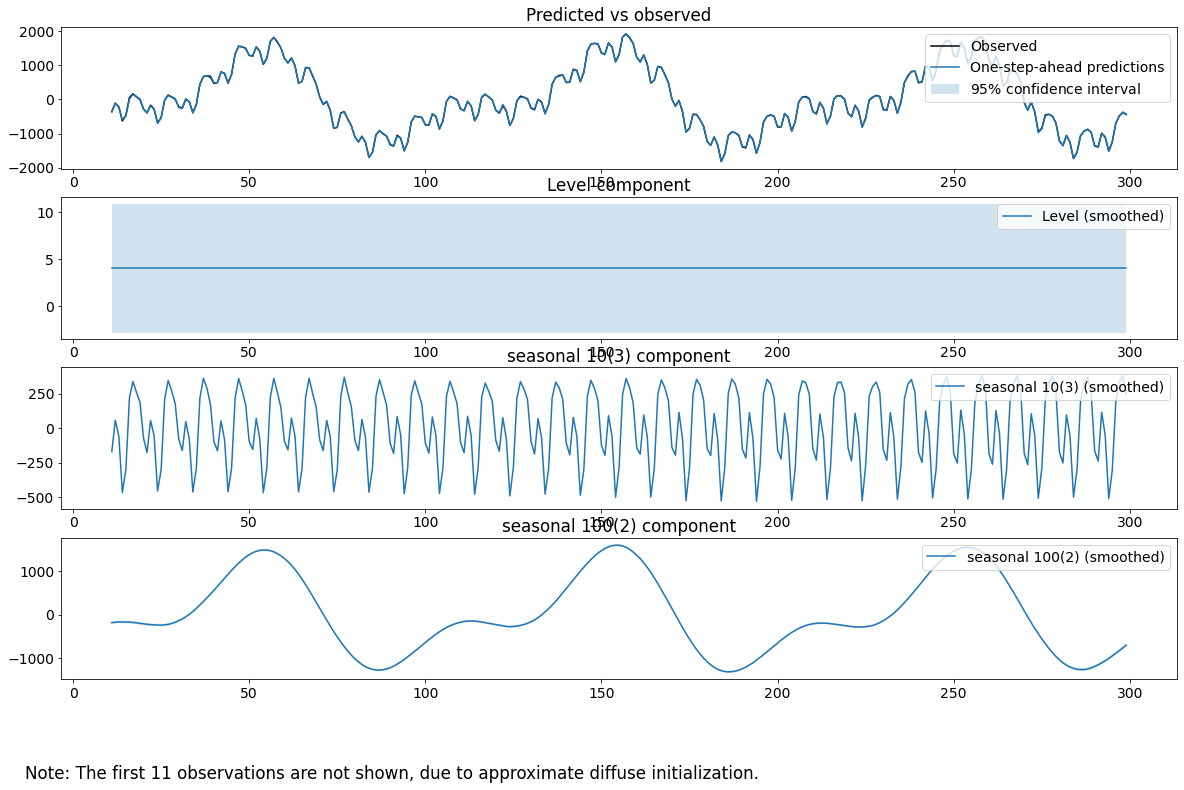

In [4]:
model = sm.tsa.UnobservedComponents(series.values,level='fixed intercept',freq_seasonal=[{'period': 10,'harmonics': 3},{'period': 100,'harmonics': 2}])
res_f = model.fit(disp=False)
print(res_f.summary())

print("L'intercept constant est estimé par : {0:.3f}".format(res_f.smoother_results.smoothed_state[0,-1:][0]))

res_f.plot_components()
plt.show()

In [5]:
model.ssm.transition[:, :, 0]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.80901699,  0.58778525,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.58778525,  0.80901699,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.30901699,  0.95105652,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -0.95105652,  0.30901699,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.30901699,  0.95105652,  0.        ,  0.        ,  0.        ,
         0.   

```{admonition} Résultat
:class: note
Les variances ajustées sont assez proches des variances véridiques de 4 et 9. Qui plus est, les composantes saisonnières individuelles semblent assez proches des vraies composantes saisonnières. Le terme de tendance lissé est assez proche du niveau réel de 10. Enfin, lesdiagnostics semblent solides; les statistiques de test sont suffisamment petites pour ne pas rejeter les trois tests.
```

## Modélisation en Domaine Mélangé

La deuxième méthode est un modèle à composantes non observées, où la tendance est modélisée comme un intercept fixe et les composantes saisonnières sont modélisées à l'aide de 10 constantes dont la somme est égale à 0 et de fonctions trigonométriques avec une périodicité primaire de 100 avec 2 harmoniques au total. Ceci ne correspond au modèle théorique sur lequel les données sont générées, car il présuppose qu'il y a plus d'erreurs pour la composante saisonnière plus courte que dans la réalité. Le processus pour la série temporelle peut être écrit comme suit :

$$
\begin{split}\begin{align}
y_t & = \mu_t + \gamma^{(1)}_t + \gamma^{(2)}_t + \varepsilon_t\\
\mu_{t+1} & = \mu_t \\
\gamma^{(1)}_{t + 1} &= - \sum_{j=1}^9 \gamma^{(1)}_{t + 1 - j} + \omega^{(1)}_t\\
\gamma^{(2)}_{j, t+1} &= \gamma^{(2)}_{j, t}\cos(\lambda_j) + \gamma^{*, (2)}_{j, t}\sin(\lambda_j) + \omega^{(2)}_{j,t}, ~j = 1, 2\\
\gamma^{*, (2)}_{j, t+1} &= -\gamma^{(2)}_{j, t}\sin(\lambda_j) + \gamma^{*, (2)}_{j, t}\cos(\lambda_j) + \omega^{*, (2)}_{j, t}, ~j = 1, 2\\
\end{align}\end{split}
$$

où $\varepsilon_t$ est un bruit blanc, $\omega^{(1)}_{t}$ sont *i.i.d.* $\mathcal N(0, \sigma^2_1)$, et $\omega^{(2)}_{j,t}$ sont *i.i.d.* suivant $\mathcal N(0, \sigma^2_2)$.

                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                  300
Model:                                fixed intercept   Log Likelihood               -1238.113
                            + stochastic seasonal(10)   AIC                           2480.226
                   + stochastic freq_seasonal(100(2))   BIC                           2487.538
Date:                                Thu, 05 Jan 2023   HQIC                          2483.157
Time:                                        23:24:50                                         
Sample:                                             0                                         
                                                - 300                                         
Covariance Type:                                  opg                                         
                                  coef    std err 

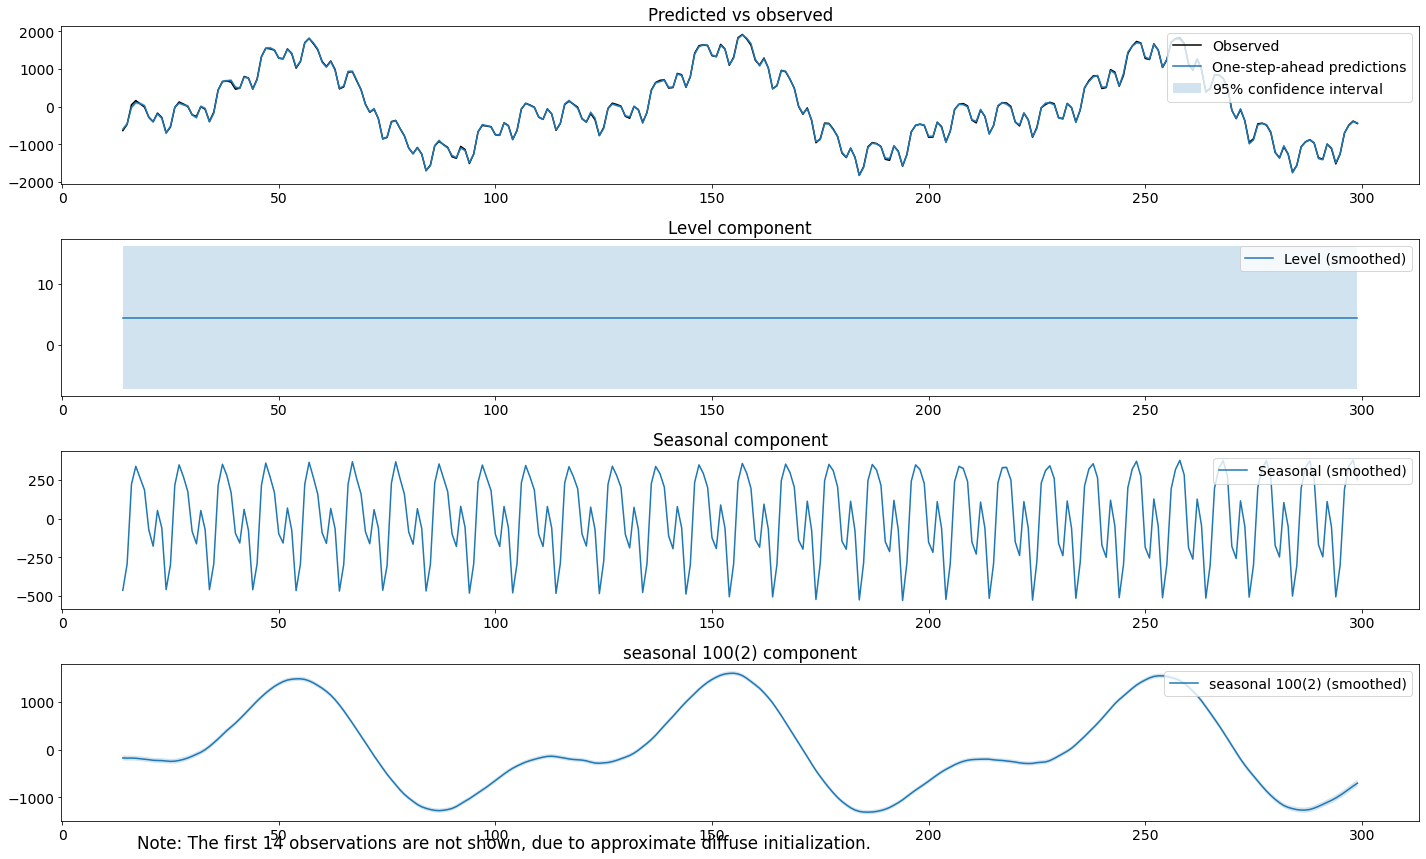

In [6]:
model = sm.tsa.UnobservedComponents(series,
                                    level='fixed intercept',
                                    seasonal=10,
                                    freq_seasonal=[{'period': 100,
                                                    'harmonics': 2}])
res_tf = model.fit(disp=False)
print(res_tf.summary())

print("Le terme fixe intercept est estimé par : {0:.3f}".format(res_tf.smoother_results.smoothed_state[0,-1:][0]))

fig = res_tf.plot_components()
fig.tight_layout(pad=1.0)

```{admonition} Bilan
:class: note
Les composantes tracées semblent bonnes. Cependant, la variance estimée du second terme saisonnier est plus arrondie par rapport à la réalité.
```

## Modélisation Paresseuse en Domaine Fréquentiel

La troisième méthode est un modèle à composantes non observées avec un intercept fixe et une composante saisonnière, qui est modélisée à l'aide de fonctions trigonométriques avec une périodicité primaire de 100 et 50 harmoniques. Cela ne correpond au modèle théorique de base, car il présuppose qu'il y a plus d'harmoniques qu'en réalité. Comme les variances sont liées, on est pas en mesure de ramener à $0$ la covariance estimée des harmoniques inexistants.

Cette spécification est qualifiée de paresseuse, car les deux composantes saisonnières différentes n'ont pas définies et sont modélisées en utilisant une seule composante avec suffisamment d'harmoniques pour couvrir les deux. Il n'est pas possible de capturer les différences de variances entre les deux véritables composantes. Le processus de la série temporelle peut être écrit comme suit :

$$
\begin{split}\begin{align}
y_t & = \mu_t + \gamma^{(1)}_t + \varepsilon_t\\
\mu_{t+1} &= \mu_t\\
\gamma^{(1)}_{t} &= \sum_{j=1}^{50}\gamma^{(1)}_{j, t}\\
\gamma^{(1)}_{j, t+1} &= \gamma^{(1)}_{j, t}\cos(\lambda_j) + \gamma^{*, (1)}_{j, t}\sin(\lambda_j) + \omega^{(1}_{j,t}, ~j = 1, 2, \dots, 50\\
\gamma^{*, (1)}_{j, t+1} &= -\gamma^{(1)}_{j, t}\sin(\lambda_j) + \gamma^{*, (1)}_{j, t}\cos(\lambda_j) + \omega^{*, (1)}_{j, t}, ~j = 1, 2, \dots, 50\\
\end{align}\end{split}
$$

où $\varepsilon_t$ est un bruit blanc, $\omega^{(1)}_{t}$ sont des variables *i.i.d.* $\mathcal N(0, \sigma^2_1)$.

                                 Unobserved Components Results                                 
Dep. Variable:                                       y   No. Observations:                  300
Model:                                 fixed intercept   Log Likelihood               -1101.455
                   + stochastic freq_seasonal(100(50))   AIC                           2204.910
Date:                                 Thu, 05 Jan 2023   BIC                           2208.204
Time:                                         23:24:56   HQIC                          2206.243
Sample:                                              0                                         
                                                 - 300                                         
Covariance Type:                                   opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

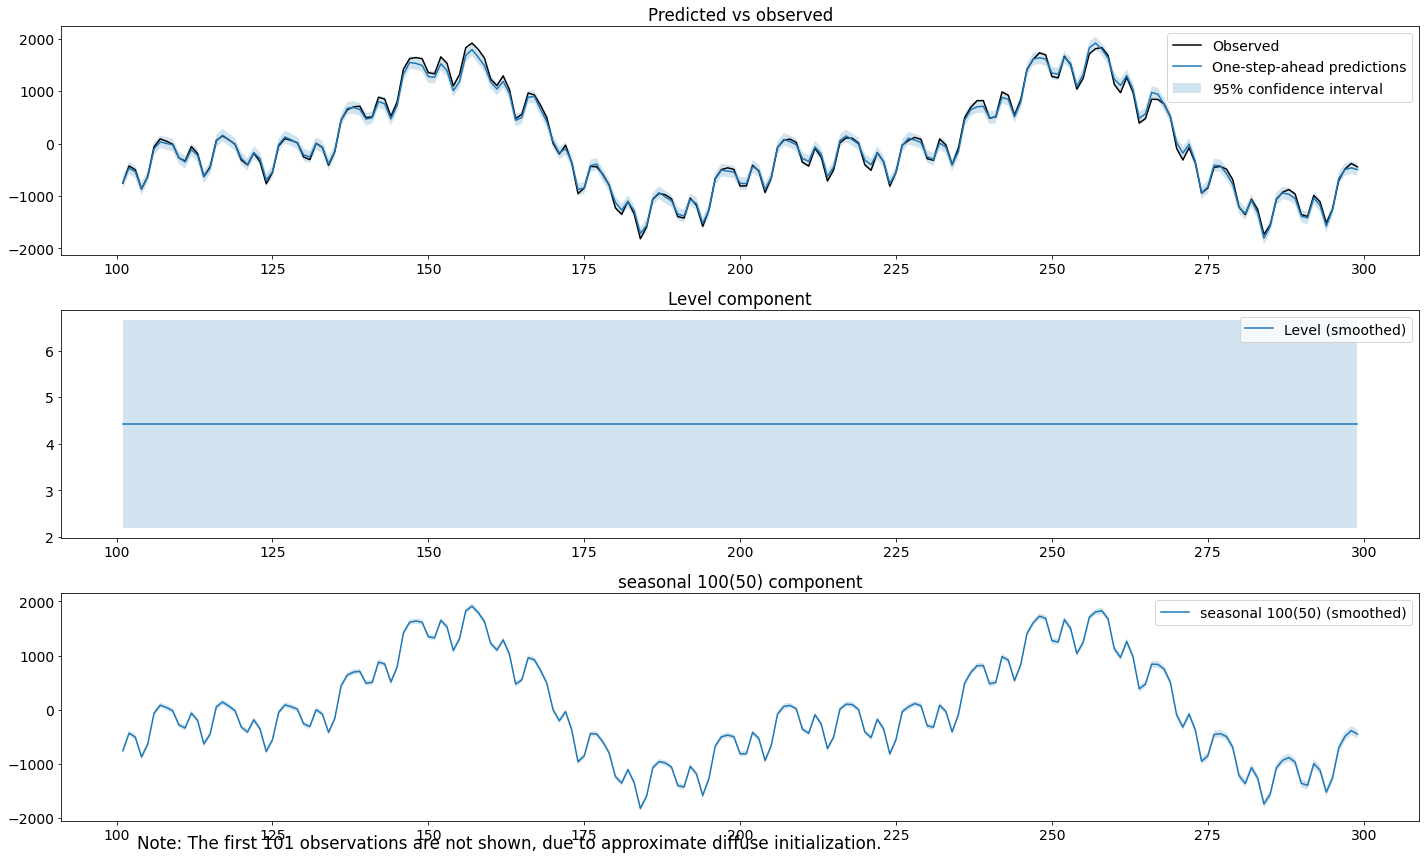

In [7]:
model = sm.tsa.UnobservedComponents(series,
                                    level='fixed intercept',
                                    freq_seasonal=[{'period': 100}])
res_lf = model.fit(disp=False)
print(res_lf.summary())

print("L'intercept fixe est estimé à : {0:.3f}".format(res_lf.smoother_results.smoothed_state[0,-1:][0]))

fig = res_lf.plot_components()
fig.tight_layout(pad=1.0)

Il est à noter l'un des tests de diagnostic élaborés ci-dessus serait rejeté au niveau $5\%$.

## Modélisation en Domaine Temporel

Maintenant, il s'agit d'un modèle à composantes non observées avec un intercept fixe et une seule composante saisonnière modélisée à l'aide d'un modèle saisonnier temporel de 100 constantes. Le processus de la série chronologique peut être écrit comme suit : 

$$
\begin{split}\begin{align}
y_t & =\mu_t + \gamma^{(1)}_t + \varepsilon_t\\
\mu_{t+1} &= \mu_{t} \\
\gamma^{(1)}_{t + 1} &= - \sum_{j=1}^{99} \gamma^{(1)}_{t + 1 - j} + \omega^{(1)}_t\\
\end{align}\end{split}
$$

où $\varepsilon_t$ est un bruit blanc, $\omega^{(1)}_{t}$ sont *i.i.d* $\mathcal N(0, \sigma^2_1)$.

                            Unobserved Components Results                             
Dep. Variable:                              y   No. Observations:                  300
Model:                        fixed intercept   Log Likelihood               -1564.378
                   + stochastic seasonal(100)   AIC                           3130.756
Date:                        Thu, 05 Jan 2023   BIC                           3134.054
Time:                                23:25:01   HQIC                          3132.091
Sample:                                     0                                         
                                        - 300                                         
Covariance Type:                          opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.seasonal  3.558e+05   2.96e+04     12.012 

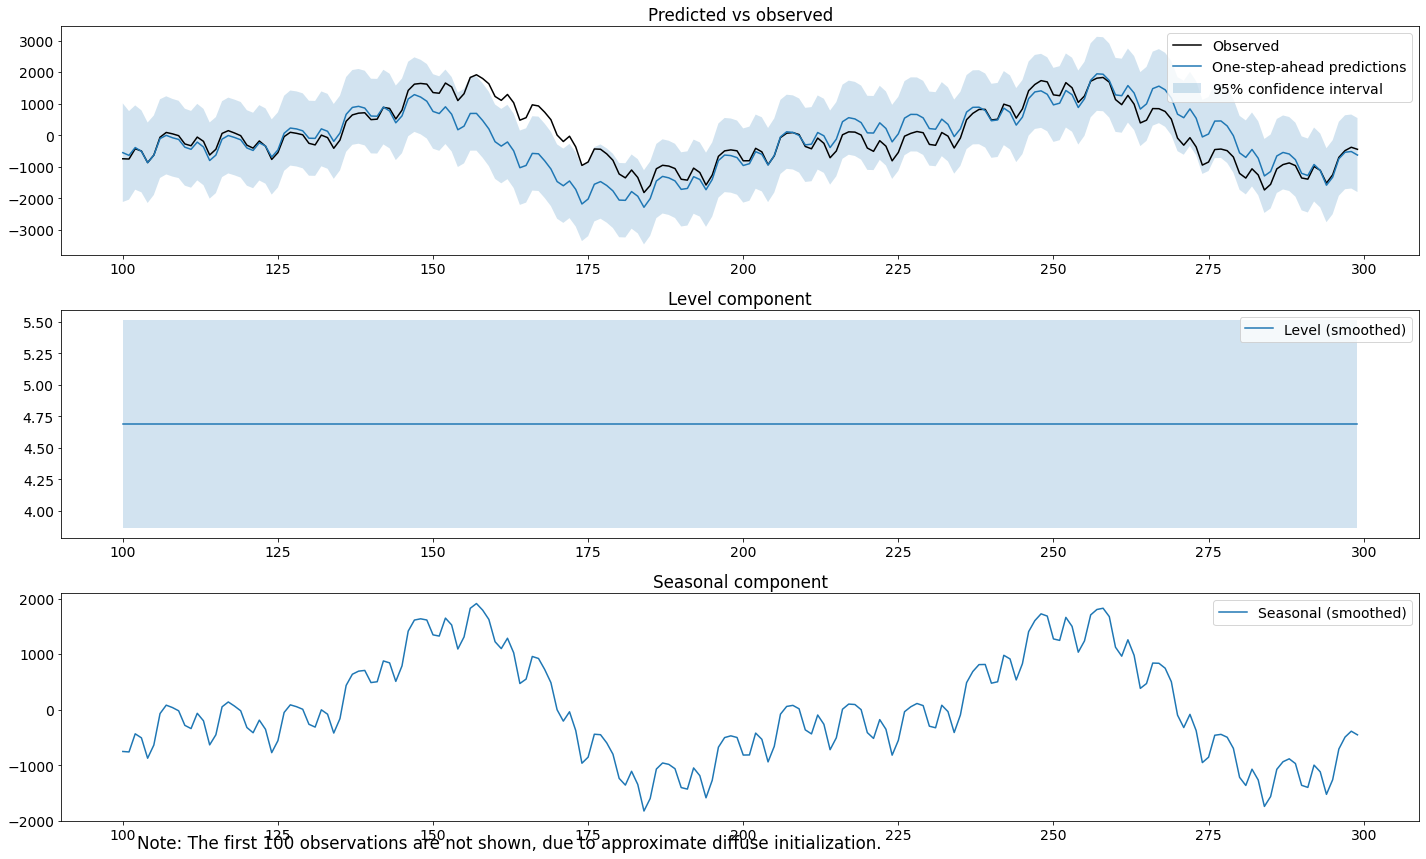

In [8]:
model = sm.tsa.UnobservedComponents(series,level='fixed intercept',seasonal=100)
res_lt = model.fit(disp=False)
print(res_lt.summary())

print("L'intercept constant est estimé par : {0:.3f}".format(res_lt.smoother_results.smoothed_state[0,-1:][0]))

fig = res_lt.plot_components()
fig.tight_layout(pad=1.0)

```{admonition} Résultat
:class: note
La composante saisonnière elle-même semble adéquate - elle constitue le principal signal. La variance estimée du terme saisonnier est très élevée, ce qui entraîne une grande incertitude dans les prédictions à un pas en avant et une faible réactivité aux nouvelles données, comme en témoignent les erreurs importantes dans les prédictions à un pas en avant et les observations. Les trois tests de diagnostic seront donc rejetés.
```

## Comparaison des Estimations

Les graphiques ci-dessous montrent qu'en modélisant explicitement les composants individuels, l'état filtré est proche de l'état réel en une demi-période environ. Les modèles paresseux ont mis plus de temps (presque une période complète) pour faire de même sur l'état réel combiné.

In [9]:
true_seasonal_10_3 = terms[0]
true_seasonal_100_2 = terms[1]
true_sum = true_seasonal_10_3 + true_seasonal_100_2

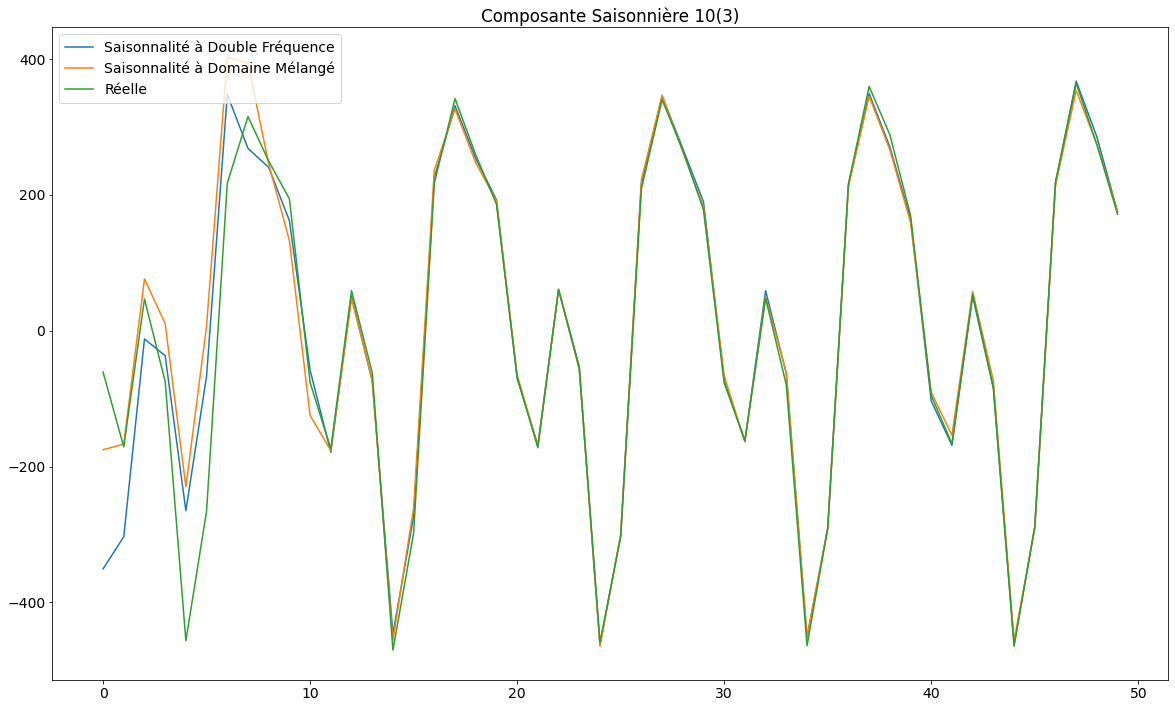

In [10]:
time_s = np.s_[:50]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
idx = np.asarray(series.index)
h1, = ax1.plot(idx[time_s], res_f.freq_seasonal[0].filtered[time_s], label='Saisonnalité à Double Fréquence')
h2, = ax1.plot(idx[time_s], res_tf.seasonal.filtered[time_s], label='Saisonnalité à Domaine Mélangé')
h3, = ax1.plot(idx[time_s], true_seasonal_10_3[time_s], label='Saisonnalité Réelle 10(3)')
plt.legend([h1, h2, h3], ['Saisonnalité à Double Fréquence','Saisonnalité à Domaine Mélangé','Réelle'], loc=2)
plt.title('Composante Saisonnière 10(3)')
plt.show()

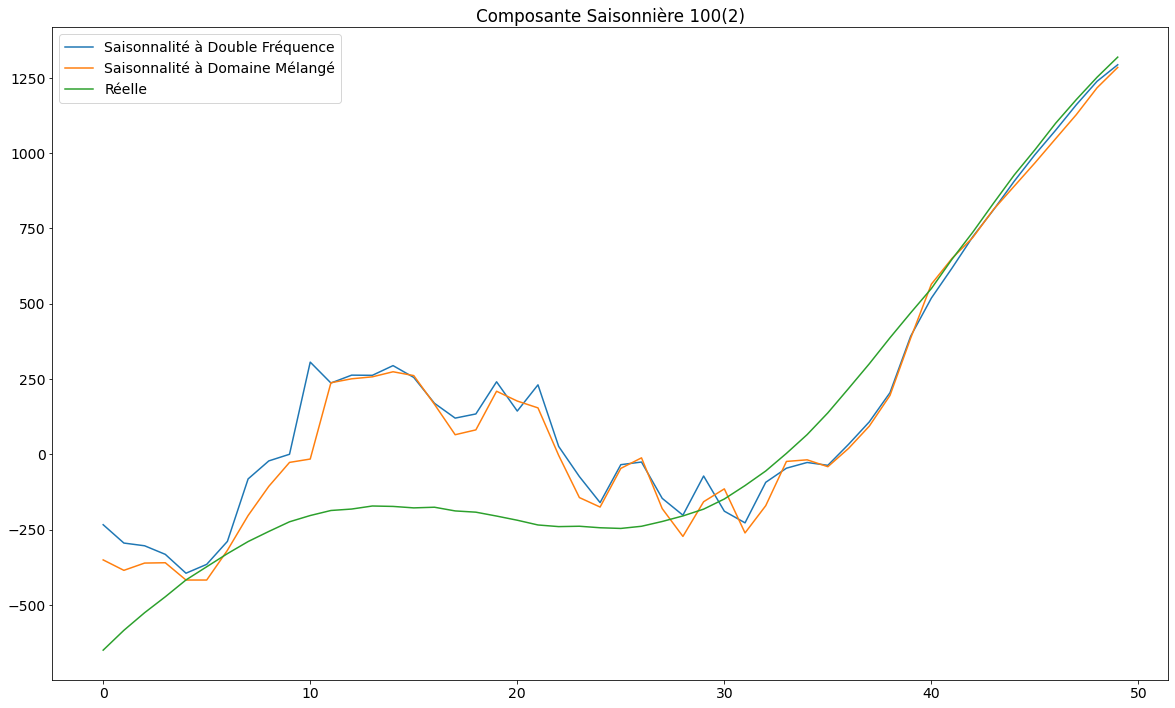

In [11]:
time_s = np.s_[:50] 
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
h21, = ax2.plot(idx[time_s], res_f.freq_seasonal[1].filtered[time_s], label='Saisonnalité à Double Fréquence')
h22, = ax2.plot(idx[time_s], res_tf.freq_seasonal[0].filtered[time_s], label='Saisonnalité à Domaine Mélangé')
h23, = ax2.plot(idx[time_s], true_seasonal_100_2[time_s], label='Saisonnalité Réelle 100(2)')
plt.legend([h21, h22, h23], ['Saisonnalité à Double Fréquence','Saisonnalité à Domaine Mélangé','Réelle'], loc=2)
plt.title('Composante Saisonnière 100(2)')
plt.show()

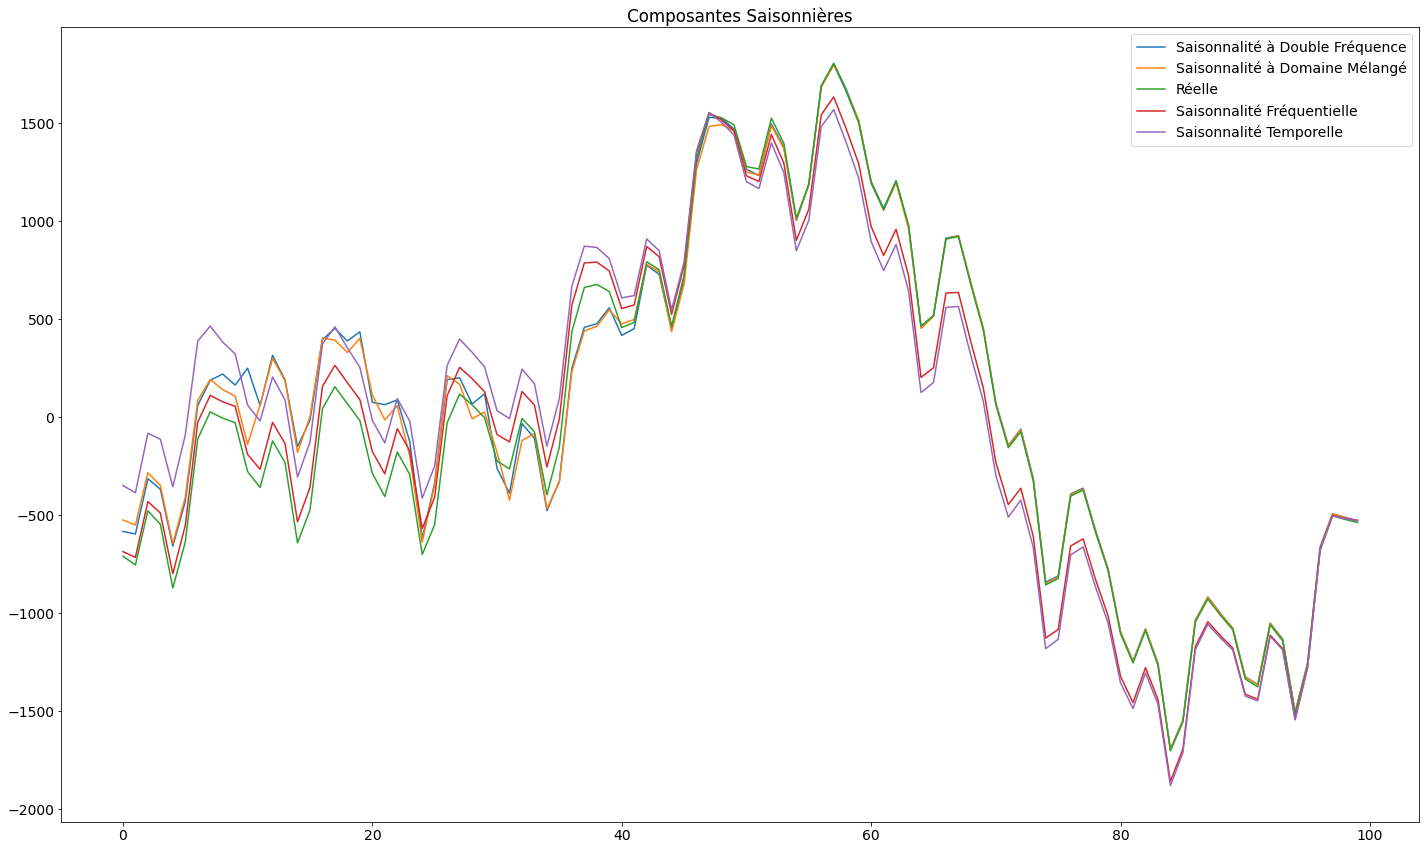

In [12]:
time_s = np.s_[:100]

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
h31, = ax3.plot(idx[time_s], res_f.freq_seasonal[1].filtered[time_s] + res_f.freq_seasonal[0].filtered[time_s], label='Saisonnalité à Double Fréquence')
h32, = ax3.plot(idx[time_s], res_tf.freq_seasonal[0].filtered[time_s] + res_tf.seasonal.filtered[time_s], label='Saisonnalité à Domaine Mélangé')
h33, = ax3.plot(idx[time_s], true_sum[time_s], label='Saisonnalité Réelle 100(2)')
h34, = ax3.plot(idx[time_s], res_lf.freq_seasonal[0].filtered[time_s], label='Lazy Freq. Seas')
h35, = ax3.plot(idx[time_s], res_lt.seasonal.filtered[time_s], label='Lazy Time Seas')

plt.legend([h31, h32, h33, h34, h35], ['Saisonnalité à Double Fréquence','Saisonnalité à Domaine Mélangé','Réelle', 'Saisonnalité Fréquentielle', 'Saisonnalité Temporelle'], loc=1)
plt.title('Composantes Saisonnières')
plt.tight_layout(pad=1.0)